# Synthetic Neural Manifolds

### Set Up + Imports

In [330]:
import setup
setup.main()
%load_ext autoreload
%autoreload 2

import neurometry.datasets.synthetic as synthetic
import numpy as np

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

import plotly.graph_objects as go
import torch

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot circle $\mathcal{S}^1$ and $N=3$ encoding vectors



We will project latent manifold $\mathcal{S}^1$ (minimal embedding dimension $d=2$) into $N$-dimensional neural state space ($N=3$) with a $d\times N$ matrix $A$. The entries of $A$ are randomly sampled from a uniform distribution $U[-1,1]$ and its columns are random encoding vectors. 

In [356]:
num_points = 100
data = synthetic.hypersphere(1, num_points)



x = data[:, 0]
y = data[:, 1]
z = np.zeros(num_points)

angles = torch.atan2(data[:, 1], data[:, 0])
normalized_angles = angles/(2*np.pi) + 1/2

colors = plt.cm.hsv(normalized_angles)


N = 10
#encoding_matrix = synthetic.random_encoding_matrix(data.shape[1], N)

place_angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

encoding_matrix = gs.vstack((gs.cos(place_angles), gs.sin(place_angles)))

vectors = [encoding_matrix[:, i] for i in range(N)]

cm = plt.get_cmap('twilight')
vector_colors = [cm(1. * i/N) for i in range(N)]
vector_colors = ['rgb({}, {}, {})'.format(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in vector_colors]



scatter = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5,color=colors), name='Data Points')

# Adding vectors as lines and cones
lines_and_cones = []
for idx, (vector, color) in enumerate(zip(vectors, vector_colors)):
    # Line (shaft of the arrow)
    lines_and_cones.append(
        go.Scatter3d(
            x=[0, vector[0]], y=[0, vector[1]], z=[0, 0],
            mode='lines', line=dict(color=color, width=5),
            name=f'Encoding Vector {idx+1}'
        )
    )
    
    # Cone (head of the arrow)
    lines_and_cones.append(
        go.Cone(
            x=[vector[0]], y=[vector[1]], z=[0], 
            u=[vector[0]/10], v=[vector[1]/10], w=[0],
            showscale=False, colorscale=[[0, color], [1, color]],
            sizemode='absolute', sizeref=0.1
        )
    )


fig = go.Figure(data=[scatter] + lines_and_cones)

fig.update_layout(
    title={
        'text': "Feature Space",
        'y':0.5,
        'x':0.1,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=25
        )
    },
    scene=dict(
        aspectmode='cube',
        xaxis=dict(range=[-1.2, 1.2], title='Feature 1'),
        yaxis=dict(range=[-1.2, 1.2], title='Feature 2'),
        zaxis=dict(range=[-1.2, 1.2], title='')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

Text(0, 0.5, 'Neurons')

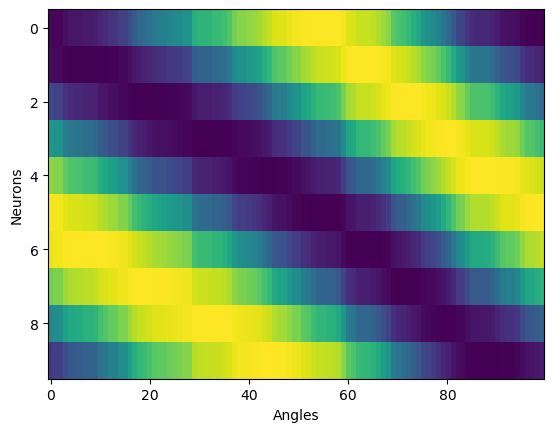

In [364]:
encoded_data = synthetic.encode_points(data, encoding_matrix)

scales = 1*gs.ones(N)
sigmoid_data = synthetic.apply_nonlinearity(encoded_data, 'sigmoid',scales=scales)

sorted_indices = torch.argsort(angles)
sorted_data_by_angles = sigmoid_data[sorted_indices,:]

plt.imshow(sorted_data_by_angles.T, aspect='auto')
plt.xlabel('Angles')
plt.ylabel('Neurons')

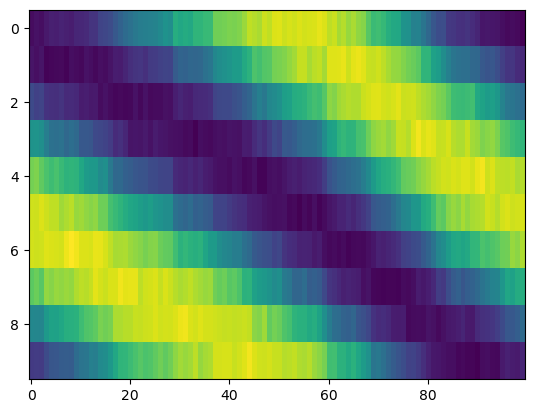

In [375]:
poisson_data = torch.poisson(10000*sorted_data_by_angles)

plt.imshow(poisson_data.T, aspect='auto')

### Encode points in higher dimensional space using encoding matrix $A: \mathbb{R}^2 \to \mathbb{R}^3$

In [323]:
transformed_encoding_vectors = synthetic.encode_points(encoding_matrix.T,encoding_matrix)

vectors = [transformed_encoding_vectors[:, i] for i in range(N)]

encoded_data = synthetic.encode_points(data, encoding_matrix)

scales = gs.array([1,1,1])
#sigmoid_data = synthetic.scaled_tanh(encoded_data, scales)
sigmoid_data = synthetic.apply_nonlinearity(encoded_data, 'tanh',scales=scales)

x = sigmoid_data[:,0]
y = sigmoid_data[:,1]
z = sigmoid_data[:,2]

scatter = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5,color=colors),name='Neural activations')

fig = go.Figure(data=scatter)

fig.update_layout(
    title={
        'text': "Neural space",
        'y':0.5,
        'x':0.1,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=25
        )
    },
    scene=dict(
        aspectmode='cube',
        xaxis=dict(range=[-1.2, 1.2], title='Neuron 1'),
        yaxis=dict(range=[-1.2, 1.2], title='Neuron 2'),
        zaxis=dict(range=[-1.2, 1.2], title='Neuron 3')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

In [328]:
N = 20
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# Calculate x and y coordinates
x = gs.cos(angles)
y = gs.sin(angles)

# Combine into a 2xN matrix
points = gs.vstack((x, y))

### Visualize cylinder ($\mathcal{S}^1 \times [0,1]$)

In [274]:
cylinder_points = synthetic.cylinder(num_points)

x = cylinder_points[:, 0]
y = cylinder_points[:, 1]
z = cylinder_points[:, 2]

scatter = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))


fig = go.Figure(data=[scatter])

fig.update_layout(
    title={
        'text': "Cylinder",
        'y':0.5,
        'x':0.1,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=25
        )
    },
    scene=dict(
        aspectmode='cube',
        xaxis=dict(range=[-1.2, 1.2], title='Feature 1'),
        yaxis=dict(range=[-1.2, 1.2], title='Feature 2'),
        zaxis=dict(range=[-1.2, 1.2], title='Feature 3')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()